In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data='/content/drive/MyDrive/tea_sickness_dataset'
dataset_dir=pathlib.Path(data)

In [ ]:
class_names = []
for x in os.walk(data):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

class_names = class_names[1:]
print(class_names)

['algal leaf', 'Anthracnose', 'healthy', 'white spot', 'brown blight', 'red leaf spot']


In [ ]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class algal leaf: 112
Images in class Anthracnose: 99
Images in class healthy: 73
Images in class white spot: 140
Images in class brown blight: 111
Images in class red leaf spot: 136


In [ ]:
# Parameter setting
batch_size = 32
img_height = 256
img_width = 256
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [ ]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size
                                                      )

Found 671 files belonging to 6 classes.
Using 537 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size
                                                    )

Found 671 files belonging to 6 classes.
Using 134 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'brown blight', 'healthy', 'red leaf spot', 'white spot']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
])

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs=60

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1  # Set to 1 for progress updates
)

Epoch 1/60
17/17 [==============================] - 1s 80ms/step - loss: 0.0842 - accuracy: 0.9907 - val_loss: 0.1776 - val_accuracy: 0.9478
Epoch 2/60
17/17 [==============================] - 1s 75ms/step - loss: 0.0781 - accuracy: 0.9907 - val_loss: 0.2086 - val_accuracy: 0.9403
Epoch 3/60
17/17 [==============================] - 1s 75ms/step - loss: 0.0628 - accuracy: 0.9926 - val_loss: 0.1949 - val_accuracy: 0.9478
Epoch 4/60
17/17 [==============================] - 1s 75ms/step - loss: 0.0647 - accuracy: 0.9926 - val_loss: 0.1905 - val_accuracy: 0.9328
Epoch 5/60
17/17 [==============================] - 1s 75ms/step - loss: 0.0827 - accuracy: 0.9814 - val_loss: 0.1648 - val_accuracy: 0.9328
Epoch 6/60
17/17 [==============================] - 1s 76ms/step - loss: 0.0822 - accuracy: 0.9814 - val_loss: 0.1729 - val_accuracy: 0.9552
Epoch 7/60
17/17 [==============================] - 1s 78ms/step - loss: 0.0673 - accuracy: 0.9888 - val_loss: 0.1778 - val_accuracy: 0.9478
Epoch 8/60
17

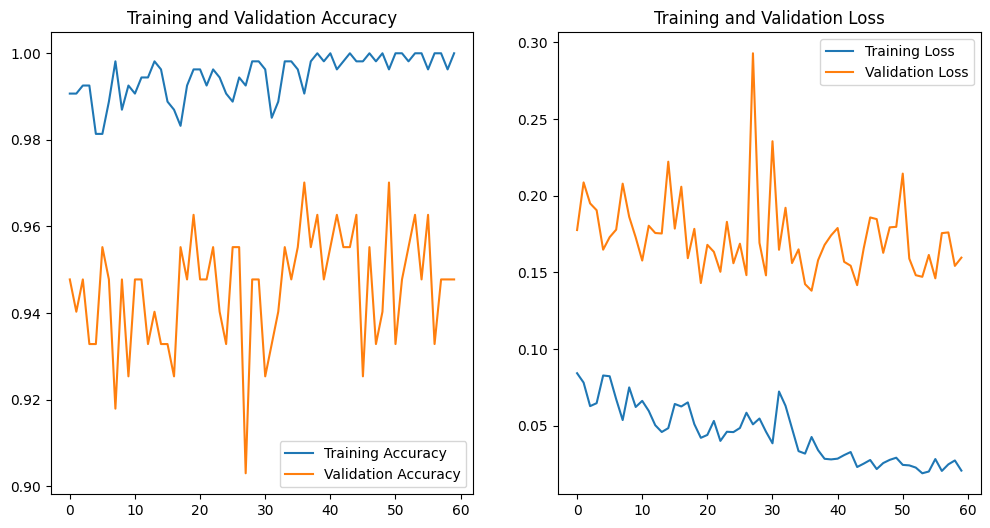

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [2 4 4 0 4 1 4 1 5 5 5 3 4 0 2 2 5 0 2 5 1 1 1 4 2 5 1 2 2 5 4 4]
Labels:
 [1 4 4 0 4 1 4 1 5 5 5 3 4 0 2 2 5 0 2 5 1 1 1 4 2 5 1 2 2 5 4 4]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.97        32
weighted avg       0.97      0.97      0.97        32



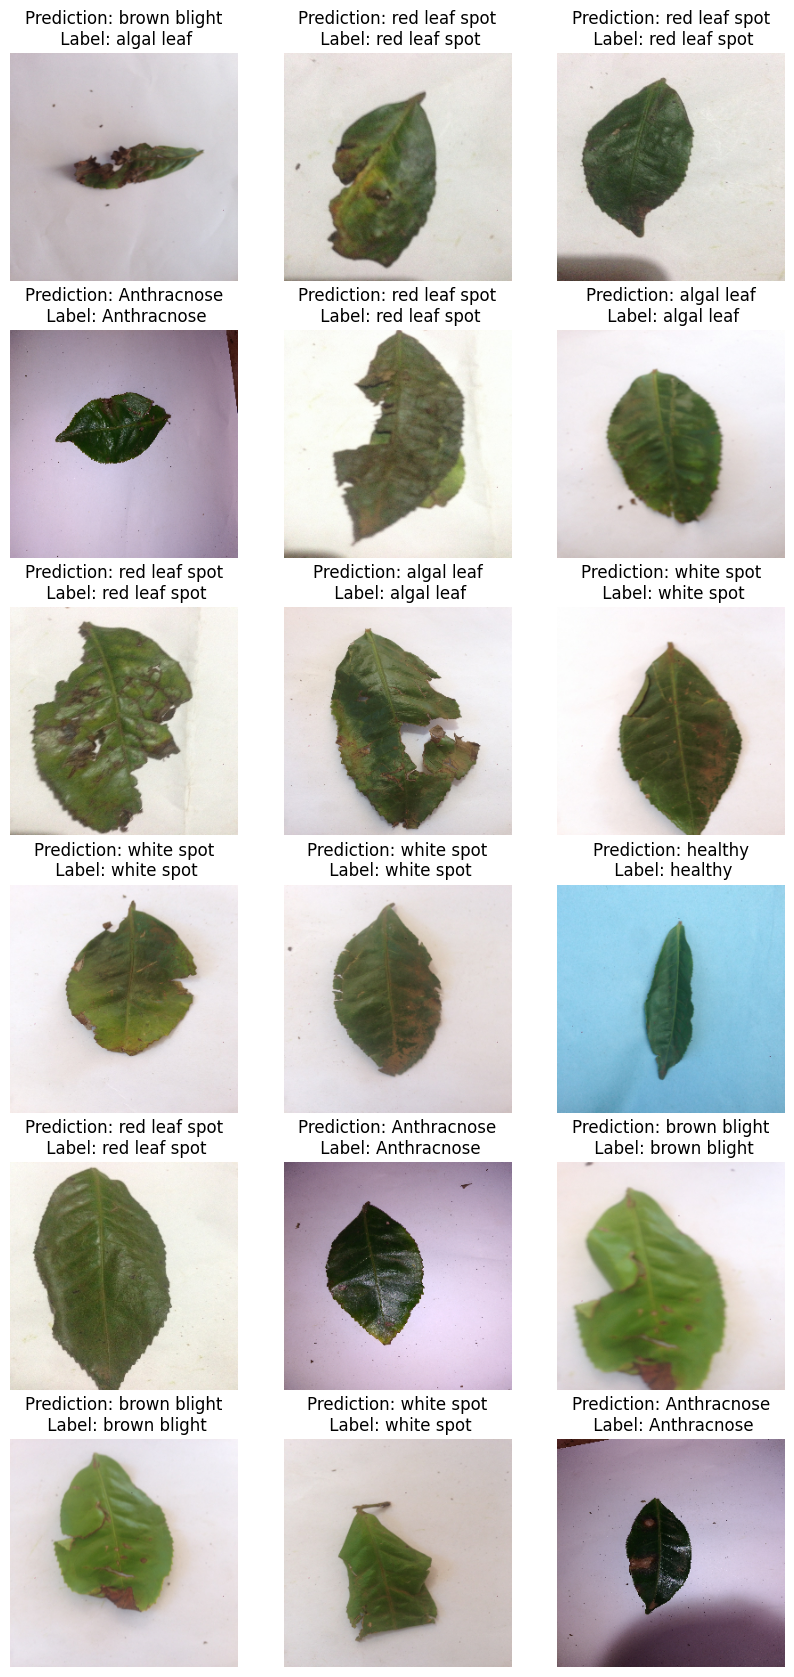

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\n Label: "+class_names[label_batch[i]])
    plt.axis("off")